# Kaggle Team Name: 22866899 (Nawal)
# Final Private Leaderboard Not Available


# Mount Google Drive

First, we mount Google Drive to access our dataset and save the trained models and preprocessing objects.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import Libraries and Load Dataset

We import the `pandas` library to handle dataframes and then load the training CSV file from Google Drive. Displaying the first 5 rows helps us quickly inspect the data structure.


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/COMP3010_Data/train.csv'
df = pd.read_csv(file_path)
df.head()


,Unnamed: 0,Tank Failure Pressure (bar),Liquid Ratio,Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),...,Status,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor ID,Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
0,3203.0,14.26,0.25,1.58,8.61,1.79,1.01,1.40,457.14,423.07,...,Superheated,37.9,-1.0,152.0,18.0,2.0,19.75,5.70,3.1,0.588298
1,3204.0,14.14,0.25,1.59,8.58,1.81,1.00,1.41,457.71,422.82,...,Superheated,37.9,-1.0,152.0,19.0,3.0,20.00,-5.15,-1.5,0.551524
2,3205.0,14.05,0.24,1.62,8.59,1.79,0.98,1.38,456.58,422.37,...,Superheated,37.9,-1.0,152.0,20.0,3.0,20.00,-5.15,0.8,0.550813
3,3206.0,14.17,0.24,1.59,8.60,1.80,0.98,1.40,456.81,423.28,...,Superheated,37.9,-1.0,152.0,21.0,3.0,20.00,-5.15,3.1,0.528906
4,3207.0,14.09,0.24,1.59,8.60,1.80,1.00,1.40,456.93,423.19,...,Superheated,37.9,-1.0,152.0,22.0,4.0,20.00,-4.90,3.4,0.454363


#Linear Regression Model Implementation

1) We import essential libraries for data handling, preprocessing, modeling, and evaluation. Then we load the raw training data from Google Drive.



2) Basic Data Cleaning: We remove unnecessary or duplicate data, and fix any invalid temperature values.


3) Create new features from existing ones to help the model learn better patterns.



4)Prepare Features and Target Variable: Drop non-numeric or irrelevant columns and separate features (X) from target (y).

5)Split Data into Training, Validation, and Test Sets: We use 70% of data for training, and 15% each for validation and testing.

6) Preprocessing Pipeline: Impute missing values with column means and scale features to zero mean and unit variance.

7)Train Linear Regression Model: We train a simple baseline regression model using the processed features.

8) Make Predictions and Evaluate Model: Calculate MAPE and R² on train, validation, and test sets.

9)Make Predictions and Evaluate Model: Calculate MAPE and R² on train, validation, and test sets.

10)Visualize Predictions vs Actuals on Validation Set: Plot a scatter plot comparing true values and model predictions on validation data.







📊 Linear Regression Results:
Train MAPE: 1.2525, R²: 0.4349
Validation MAPE: 1.2578, R²: 0.4812
Test MAPE: 1.2047, R²: 0.4508


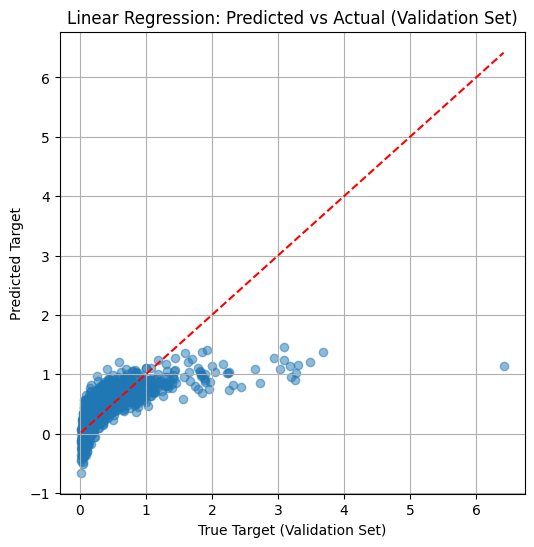

In [21]:
# 1) --- Import required libraries ---

import pandas as pd  # For handling data in DataFrames
import numpy as np   # For numerical operations
from sklearn.model_selection import train_test_split  # To split data into train/val/test sets
from sklearn.preprocessing import StandardScaler      # To scale numeric features to standard normal
from sklearn.linear_model import LinearRegression     # Simple regression model
from sklearn.metrics import mean_absolute_percentage_error, r2_score  # Evaluation metrics
from sklearn.impute import SimpleImputer              # To handle missing values
from sklearn.pipeline import Pipeline                 # To build preprocessing steps
import matplotlib.pyplot as plt  # To visualize prediction vs true values

#--- Load raw training data ---

data_path = '/content/drive/My Drive/COMP3010_Data/train.csv'
df = pd.read_csv(data_path)

# 2) --- Basic cleaning ---

df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # Drop extra index column if present
df = df.drop_duplicates()  # Remove duplicate rows
df = df[df['Target Pressure (bar)'].notnull()]  # Drop rows with missing target values
df = df.dropna(axis=1, how='all')  # Drop columns that are entirely NaN

# --- Fix invalid temperature values ---

kelvin_cols = ['Vapour Temperature (K)', 'Liquid Temperature (K)',
               'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']

for col in kelvin_cols:
    if col in df.columns:
        # Replace negative temperatures (invalid in Kelvin) with NaN
        df[col] = df[col].mask(df[col] < 0, np.nan)

df = df.dropna(axis=1, how='all')  # Drop columns that became entirely NaN after fixing

# 3) --- Feature engineering ---

# Add Tank Aspect Ratio: Width divided by Length
if 'Tank Width (m)' in df.columns and 'Tank Length (m)' in df.columns:
    df['Tank Aspect Ratio'] = df['Tank Width (m)'] / df['Tank Length (m)']
else:
    df['Tank Aspect Ratio'] = np.nan

# Add Tank Volume: Width × Length × Height
if all(col in df.columns for col in ['Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)']):
    df['Tank Volume (m3)'] = df['Tank Width (m)'] * df['Tank Length (m)'] * df['Tank Height (m)']
else:
    df['Tank Volume (m3)'] = np.nan

# 5) --- Prepare features and target ---

# Drop non-numeric or unused features ('Sensor ID' and 'Status' dropped intentionally)
X = df.drop(columns=['Target Pressure (bar)', 'Sensor ID', 'Status'], errors='ignore')
y = df['Target Pressure (bar)']  # Target variable

# 6) --- Split data into Train / Validation / Test (70/15/15 split) ---

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)
# 0.1765 * 0.85 ≈ 0.15, so overall test/val split remains 15%

# --- Preprocessing pipeline for numeric features ---

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Replace missing values with column mean
    ('scaler', StandardScaler())                  # Scale features to mean=0, std=1
])

# Apply pipeline to train/val/test features
X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)
X_test_processed = pipeline.transform(X_test)

# --- Train Linear Regression Model ---

model = LinearRegression()
model.fit(X_train_processed, y_train)  # We use original y_train (not scaled)

# --- Make Predictions ---

train_pred = model.predict(X_train_processed)
val_pred = model.predict(X_val_processed)
test_pred = model.predict(X_test_processed)

# --- Evaluate Model ---

train_mape = mean_absolute_percentage_error(y_train, train_pred)
val_mape = mean_absolute_percentage_error(y_val, val_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

# --- Print Results ---

print("📊 Linear Regression Results:")
print(f"Train MAPE: {train_mape:.4f}, R²: {train_r2:.4f}")
print(f"Validation MAPE: {val_mape:.4f}, R²: {val_r2:.4f}")
print(f"Test MAPE: {test_mape:.4f}, R²: {test_r2:.4f}")

# --- Visualize Predictions vs Actuals on Validation Set ---

plt.figure(figsize=(6, 6))
plt.scatter(y_val, val_pred, alpha=0.5)
plt.xlabel("True Target (Validation Set)")
plt.ylabel("Predicted Target")
plt.title("Linear Regression: Predicted vs Actual (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Perfect prediction line
plt.grid(True)
plt.show()


# Hyperparameter Tuning
- Define Ridge regression model and tune regularization strength with grid search.
- Train model with best alpha and predict on train, val, and test sets.
- Evaluate predictions using MAPE and R² metrics.
- Plot predicted vs actual values on validation set for visual assessment.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
📊 Ridge Regression Results:
Best alpha: 100
Train MAPE: 1.1549, R²: 0.3974
Validation MAPE: 1.1776, R²: 0.4376
Test MAPE: 1.1450, R²: 0.3974


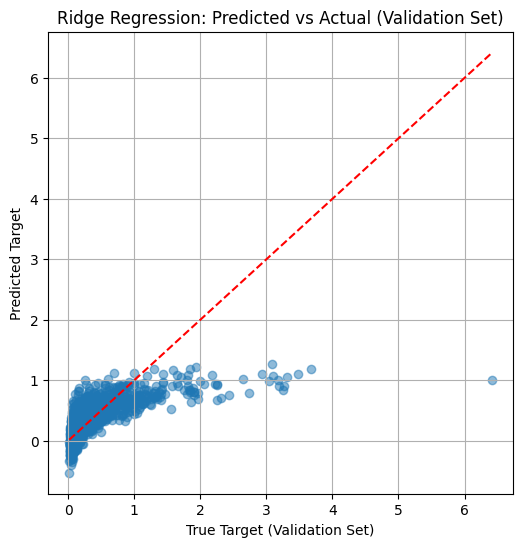

In [22]:
# --- Import required libraries ---

import pandas as pd  # For loading and manipulating data
import numpy as np   # For numerical operations

from sklearn.model_selection import train_test_split, GridSearchCV  # For data splitting and hyperparameter tuning
from sklearn.preprocessing import StandardScaler  # To scale numeric features
from sklearn.linear_model import Ridge  # Ridge regression model (L2 regularization)
from sklearn.metrics import mean_absolute_percentage_error, r2_score  # Evaluation metrics
from sklearn.impute import SimpleImputer  # To fill missing values
from sklearn.pipeline import Pipeline  # For chaining preprocessing steps
import matplotlib.pyplot as plt  # For plotting results

# --- Load raw training data ---

data_path = '/content/drive/My Drive/COMP3010_Data/train.csv'
df = pd.read_csv(data_path)

# --- Basic data cleaning ---

df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # Drop unnecessary index column if present
df = df.drop_duplicates()  # Remove duplicate rows
df = df[df['Target Pressure (bar)'].notnull()]  # Remove rows with missing target values
df = df.dropna(axis=1, how='all')  # Drop columns that are completely empty

# --- Fix invalid Kelvin values (e.g., negative temperatures) ---

kelvin_cols = ['Vapour Temperature (K)', 'Liquid Temperature (K)',
               'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']
for col in kelvin_cols:
    if col in df.columns:
        df[col] = df[col].mask(df[col] < 0, np.nan)  # Replace negatives with NaN

df = df.dropna(axis=1, how='all')  # Drop columns that became fully NaN

# --- Feature Engineering ---

# Tank Aspect Ratio = Width / Length
if 'Tank Width (m)' in df.columns and 'Tank Length (m)' in df.columns:
    df['Tank Aspect Ratio'] = df['Tank Width (m)'] / df['Tank Length (m)']
else:
    df['Tank Aspect Ratio'] = np.nan

# Tank Volume = Width × Length × Height
if all(col in df.columns for col in ['Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)']):
    df['Tank Volume (m3)'] = df['Tank Width (m)'] * df['Tank Length (m)'] * df['Tank Height (m)']
else:
    df['Tank Volume (m3)'] = np.nan

# Convert non-numeric columns to strings (helps avoid type errors)
if 'Status' in df.columns:
    df['Status'] = df['Status'].astype(str)
if 'Sensor ID' in df.columns:
    df['Sensor ID'] = df['Sensor ID'].astype(str)

# --- Define features and target ---

# Drop non-numeric columns ('Sensor ID', 'Status') since we're using numeric preprocessing only
X = df.drop(columns=['Target Pressure (bar)', 'Sensor ID', 'Status'], errors='ignore')
y = df['Target Pressure (bar)']  # Target variable

# --- Split into Train / Validation / Test sets (70/15/15) ---

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)
# (0.1765 * 0.85 ≈ 0.15) → consistent 70/15/15 split

# --- Preprocessing pipeline (imputation + scaling) ---

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with column mean
    ('scaler', StandardScaler())  # Standardize features (mean=0, std=1)
])

X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)
X_test_processed = pipeline.transform(X_test)

# --- Define Ridge Regression and Hyperparameter Grid ---

ridge = Ridge(random_state=42)
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  # Strength of regularization
}

# --- Grid Search (5-fold cross-validation) for best alpha ---

grid_search = GridSearchCV(estimator=ridge,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_percentage_error',
                           n_jobs=-1,  # Use all processors
                           verbose=1)

grid_search.fit(X_train_processed, y_train)  # Fit on training set only

# --- Get best model and predict ---

best_ridge = grid_search.best_estimator_

train_pred = best_ridge.predict(X_train_processed)
val_pred = best_ridge.predict(X_val_processed)
test_pred = best_ridge.predict(X_test_processed)

# --- Evaluate model performance ---

train_mape = mean_absolute_percentage_error(y_train, train_pred)
val_mape = mean_absolute_percentage_error(y_val, val_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

# --- Print final results ---

print("📊 Ridge Regression Results:")
print("Best alpha:", grid_search.best_params_['alpha'])
print(f"Train MAPE: {train_mape:.4f}, R²: {train_r2:.4f}")
print(f"Validation MAPE: {val_mape:.4f}, R²: {val_r2:.4f}")
print(f"Test MAPE: {test_mape:.4f}, R²: {test_r2:.4f}")

# --- Visualize predictions vs actuals on validation set ---

plt.figure(figsize=(6, 6))
plt.scatter(y_val, val_pred, alpha=0.5)
plt.xlabel("True Target (Validation Set)")
plt.ylabel("Predicted Target")
plt.title("Ridge Regression: Predicted vs Actual (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Perfect prediction line
plt.grid(True)
plt.show()


# Random Forest Model
1) Import libraries and load the dataset.

2) Clean data by dropping duplicates, missing targets, and invalid Kelvin temperatures.

3) Engineer features: Tank Aspect Ratio and Tank Volume.

4) Separate features and target, dropping non-numeric columns.

5)Split data into train (70%), validation (15%), and test (15%) sets.

6)Preprocess features with mean imputation and scaling pipeline.

7) Train Random Forest regressor with 50 trees and partial sampling

8)Predict and evaluate model performance using MAPE and R² on train, val, and test sets.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# --- Load raw training data ---
data_path = '/content/drive/My Drive/COMP3010_Data/train.csv'
df = pd.read_csv(data_path)

# --- Basic cleaning ---
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.drop_duplicates()
df = df[df['Target Pressure (bar)'].notnull()]
df = df.dropna(axis=1, how='all')

# Fix negative kelvin temps
kelvin_cols = ['Vapour Temperature (K)', 'Liquid Temperature (K)',
               'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']
for col in kelvin_cols:
    if col in df.columns:
        df[col] = df[col].mask(df[col] < 0, np.nan)
df = df.dropna(axis=1, how='all')

# --- Feature engineering ---
df['Tank Aspect Ratio'] = df['Tank Width (m)'] / df['Tank Length (m)']
df['Tank Volume (m3)'] = df['Tank Width (m)'] * df['Tank Length (m)'] * df['Tank Height (m)']

# --- Prepare features and target ---
X = df.drop(columns=['Target Pressure (bar)', 'Sensor ID', 'Status'], errors='ignore')
y = df['Target Pressure (bar)']

# --- Train-validation-test split ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

# --- Preprocessing pipeline ---
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)
X_test_processed = pipeline.transform(X_test)

# --- Train Random Forest WITHOUT tuning ---
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    max_samples=0.6,

)
rf.fit(X_train_processed, y_train)

# --- Predict & Evaluate ---
train_pred = rf.predict(X_train_processed)
val_pred = rf.predict(X_val_processed)
test_pred = rf.predict(X_test_processed)

print("\n📊 Random Forest Results (No Tuning):")
print(f"Train MAPE: {mean_absolute_percentage_error(y_train, train_pred):.4f}, R²: {r2_score(y_train, train_pred):.4f}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, val_pred):.4f}, R²: {r2_score(y_val, val_pred):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, test_pred):.4f}, R²: {r2_score(y_test, test_pred):.4f}")



📊 Random Forest Results (No Tuning):
Train MAPE: 0.1325, R²: 0.9477
Validation MAPE: 0.2280, R²: 0.8528
Test MAPE: 0.2506, R²: 0.8317


# Hyperparameter Tuning
- Set up Random Forest with GridSearchCV to tune max_depth (20 or None), n_estimators fixed at 100, and min_samples_split=2.
- Fit grid search on training data with 2-fold CV optimizing R² score.
- Retrieve best model and predict on train, validation, and test sets.
- Evaluate performance using MAPE and R² metrics and print the best hyperparameters found.

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

# --- Load and preprocess the data (same as before) ---
data_path = '/content/drive/My Drive/COMP3010_Data/train.csv'
df = pd.read_csv(data_path)

df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.drop_duplicates()
df = df[df['Target Pressure (bar)'].notnull()]
df = df.dropna(axis=1, how='all')

kelvin_cols = ['Vapour Temperature (K)', 'Liquid Temperature (K)',
               'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']
for col in kelvin_cols:
    if col in df.columns:
        df[col] = df[col].mask(df[col] < 0, np.nan)
df = df.dropna(axis=1, how='all')

df['Tank Aspect Ratio'] = df['Tank Width (m)'] / df['Tank Length (m)']
df['Tank Volume (m3)'] = df['Tank Width (m)'] * df['Tank Length (m)'] * df['Tank Height (m)']

X = df.drop(columns=['Target Pressure (bar)', 'Sensor ID', 'Status'], errors='ignore')
y = df['Target Pressure (bar)']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)
X_test_processed = pipeline.transform(X_test)

# --- Train Random Forest WITH GridSearchCV tuning ---
param_grid = {
    'n_estimators': [100],
    'max_depth': [20, None],
    'min_samples_split': [2]
}
rf = RandomForestRegressor(random_state=42, max_samples=0.8)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=2, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, y_train)
best_rf = grid_search.best_estimator_

# --- Predict & Evaluate ---
train_pred = best_rf.predict(X_train_processed)
val_pred = best_rf.predict(X_val_processed)
test_pred = best_rf.predict(X_test_processed)

print("\n Random Forest Results (With Tuning):")
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Train MAPE: {mean_absolute_percentage_error(y_train, train_pred):.4f}, R²: {r2_score(y_train, train_pred):.4f}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, val_pred):.4f}, R²: {r2_score(y_val, val_pred):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, test_pred):.4f}, R²: {r2_score(y_test, test_pred):.4f}")


Fitting 2 folds for each of 2 candidates, totalling 4 fits

📊 Random Forest Results (With Tuning):
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Train MAPE: 0.1006, R²: 0.9669
Validation MAPE: 0.2114, R²: 0.8482
Test MAPE: 0.2311, R²: 0.8474


# Neural Networks (Main Model)

1) Data Loading & Cleaning: Imported dataset, removed duplicates, dropped irrelevant or all-NaN columns, and fixed invalid negative Kelvin temperatures.

2) Feature Engineering: Created two new features — Tank Aspect Ratio and Tank Volume — using available dimensions.

3) Data Splitting: Split the data into training (70%), validation (15%), and test (15%) sets using train_test_split.

4) Preprocessing Pipeline: Applied mean imputation for missing values and standardized all numerical features using StandardScaler.

5) Target Scaling: Target variable (Target Pressure) was scaled using StandardScaler to improve model learning.

6) Baseline Model: Defined and trained a simple MLP model with two hidden layers (128 and 64 neurons), ReLU activation, and no hyperparameter tuning.

7) Training: Trained the model for 250 epochs with batch size 64 using the Adam optimizer and MAE loss function.

8)Evaluation: Predicted on train, validation, and test sets; inverse-transformed predictions and calculated MAPE and R² for performance assessment.


In [39]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import joblib  # For saving/loading models or scalers (not used here but commonly helpful)
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.impute import SimpleImputer  # To handle missing values
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.pipeline import Pipeline  # For chaining preprocessing steps
from sklearn.metrics import mean_absolute_percentage_error, r2_score  # For evaluation metrics

# Import TensorFlow and Keras for building the neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Load the dataset from Google Drive
data_path = '/content/drive/My Drive/COMP3010_Data/train.csv'
df = pd.read_csv(data_path)

# Drop unwanted unnamed column if present
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Remove duplicate rows from the dataset
df = df.drop_duplicates()

# Keep only rows that have a non-null target value
df = df[df['Target Pressure (bar)'].notnull()]

# Drop any column where all values are NaN
df = df.dropna(axis=1, how='all')

# List of temperature columns that should not have negative values (Kelvin can't be negative)
kelvin_cols = ['Vapour Temperature (K)', 'Liquid Temperature (K)',
               'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']

# Replace negative values in temperature columns with NaN
for col in kelvin_cols:
    if col in df.columns:
        df[col] = df[col].mask(df[col] < 0, np.nan)

# Drop columns that became entirely NaN after masking
df = df.dropna(axis=1, how='all')

# Create new feature: tank aspect ratio (width / length)
df['Tank Aspect Ratio'] = df['Tank Width (m)'] / df['Tank Length (m)']

# Create new feature: tank volume = width × length × height
df['Tank Volume (m3)'] = df['Tank Width (m)'] * df['Tank Length (m)'] * df['Tank Height (m)']

# Define input features (drop target and identifiers)
X = df.drop(columns=['Target Pressure (bar)', 'Sensor ID', 'Status'], errors='ignore')

# Define target variable
y = df['Target Pressure (bar)']

# Split data into temporary train+val set and test set (15% for testing)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split remaining temp set into train and validation sets (15% of 85% = ~15%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

# Create preprocessing pipeline for imputing and scaling features
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
    ('scaler', StandardScaler())  # Scale features to standard normal distribution
])

# Fit pipeline on training data and transform train, val, and test sets
X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)
X_test_processed = pipeline.transform(X_test)

# Scale target variable using StandardScaler
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1,1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1,1)).flatten()

# Define a simple baseline MLP model with 2 hidden layers
def build_baseline_model(input_dim):
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),  # Input layer
        layers.Dense(128, activation='relu'),  # First hidden layer with 128 neurons
        layers.Dense(64, activation='relu'),   # Second hidden layer with 64 neurons
        layers.Dense(1)  # Output layer for regression
    ])
    # Compile the model with MAE loss and MAPE metric
    model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

# Set random seed for reproducibility
tf.keras.utils.set_random_seed(42)

# Build the model using the number of features as input dimension
baseline_model = build_baseline_model(X_train_processed.shape[1])

# Train the model for 250 epochs using batch size 64 and validation data
history_baseline = baseline_model.fit(
    X_train_processed, y_train_scaled,  # Scaled training data
    validation_data=(X_val_processed, y_val_scaled),  # Scaled validation data
    epochs=250,  # Total number of training epochs
    batch_size=64,  # Batch size
    verbose=1  # Show training output
)

# Define evaluation function to inverse scale predictions and calculate metrics
def evaluate(model, X, y_true, desc):
    y_pred_scaled = model.predict(X).flatten()  # Predict and flatten
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()  # Inverse scale predictions
    mape = mean_absolute_percentage_error(y_true, y_pred)  # Compute MAPE
    r2 = r2_score(y_true, y_pred)  # Compute R²
    print(f"{desc} MAPE: {mape:.4f}, R2: {r2:.4f}")  # Print results
    return y_pred

# Evaluate the baseline model on train, validation, and test sets
print("\nBaseline Model Results:")
evaluate(baseline_model, X_train_processed, y_train, 'Train')  # Train evaluation
evaluate(baseline_model, X_val_processed, y_val, 'Validation')  # Validation evaluation
evaluate(baseline_model, X_test_processed, y_test, 'Test')  # Test evaluation


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.4571 - mean_absolute_percentage_error: 234.6503 - val_loss: 0.3593 - val_mean_absolute_percentage_error: 119.3199
Epoch 2/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3293 - mean_absolute_percentage_error: 177.0769 - val_loss: 0.2951 - val_mean_absolute_percentage_error: 102.8145
Epoch 3/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2679 - mean_absolute_percentage_error: 152.9853 - val_loss: 0.2499 - val_mean_absolute_percentage_error: 91.9100
Epoch 4/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2328 - mean_absolute_percentage_error: 161.4041 - val_loss: 0.2310 - val_mean_absolute_percentage_error: 90.5228
Epoch 5/250
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2116 - mean_absolute_percentage_error: 166.1049 - val_loss: 0.2115 - val_mean_absolute_percentage_erro

array([0.45622328, 0.08446801, 0.32320964, ..., 0.10213513, 0.33879814,
       0.03078151], dtype=float32)

# Hyperparameter Tuning
1) A manual grid search was used to explore combinations of key hyperparameters:

- layer1_units: number of neurons in the first dense layer.

- layer2_units: number of neurons in the second dense layer.

- dropout_rate: regularization to prevent overfitting.

- learning_rate: controls the optimizer step size.

2) For each hyperparameter combination:
- A Sequential MLP model is built using ReLU activations.
- L2 regularization and Batch Normalization are applied for stability.
- Dropout is used after each dense layer to reduce overfitting.
- Each model is trained on the training set and evaluated on the validation set using MAPE.
- Early stopping is used with patience=20 to stop training if validation performance stops improving.

3)The model with the lowest validation MAPE is selected as the best model.

4)The best hyperparameters and validation MAPE are printed at the end.

In [41]:
# Hyperparameter tuning and final model training

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Load and preprocess data (same as baseline)
data_path = '/content/drive/My Drive/COMP3010_Data/train.csv'
df = pd.read_csv(data_path)
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.drop_duplicates()
df = df[df['Target Pressure (bar)'].notnull()]
df = df.dropna(axis=1, how='all')

kelvin_cols = ['Vapour Temperature (K)', 'Liquid Temperature (K)',
               'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']
for col in kelvin_cols:
    if col in df.columns:
        df[col] = df[col].mask(df[col] < 0, np.nan)
df = df.dropna(axis=1, how='all')

df['Tank Aspect Ratio'] = df['Tank Width (m)'] / df['Tank Length (m)']
df['Tank Volume (m3)'] = df['Tank Width (m)'] * df['Tank Length (m)'] * df['Tank Height (m)']

X = df.drop(columns=['Target Pressure (bar)', 'Sensor ID', 'Status'], errors='ignore')
y = df['Target Pressure (bar)']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)
X_test_processed = pipeline.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1,1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1,1)).flatten()

# Hyperparameter grid
param_grid = {
    'layer1_units': [512, 256],
    'layer2_units': [256, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.0001, 0.001]
}

best_val_mape = float('inf')
best_params = None
best_model = None

print("Starting hyperparameter tuning...")

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")

    def build_tuned_model(input_dim):
        model = keras.Sequential([
            keras.Input(shape=(input_dim,)),
            layers.Dense(params['layer1_units'], activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(params['dropout_rate']),
            layers.Dense(params['layer2_units'], activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(params['dropout_rate']),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss='mae',
            metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
        )
        return model

    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(42)
    model = build_tuned_model(X_train_processed.shape[1])

    early_stop = callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    history = model.fit(
        X_train_processed, y_train_scaled,
        validation_data=(X_val_processed, y_val_scaled),
        epochs=100,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    val_pred_scaled = model.predict(X_val_processed).flatten()
    val_pred = target_scaler.inverse_transform(val_pred_scaled.reshape(-1,1)).flatten()
    val_mape = mean_absolute_percentage_error(y_val, val_pred)

    print(f"Validation MAPE: {val_mape:.4f}")

    if val_mape < best_val_mape:
        best_val_mape = val_mape
        best_params = params
        best_model = model

print("\nBest Hyperparameters found:", best_params)
print(f"Best Validation MAPE: {best_val_mape:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting hyperparameter tuning...
Testing params: {'dropout_rate': 0.2, 'layer1_units': 512, 'layer2_units': 256, 'learning_rate': 0.0001}
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation MAPE: 0.2203
Testing params: {'dropout_rate': 0.2, 'layer1_units': 512, 'layer2_units': 256, 'learning_rate': 0.001}
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation MAPE: 0.1731
Testing params: {'dropout_rate': 0.2, 'layer1_units': 512, 'layer2_units': 128, 'learning_rate': 0.0001}
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation MAPE: 0.2343
Testing params: {'dropout_rate': 0.2, 'layer1_units': 512, 'layer2_units': 128, 'learning_rate': 0.001}
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation MAPE: 0.1837
Testing params: {'dropout_rate': 0.2, 'layer1_units': 256, 'layer2_units': 256, 'learning_rate': 0.0001}
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Validation MAPE: 0.230

# Final Trained Model

1) A new MLP model is built using the best hyperparameters found during tuning.
The architecture includes:
- Two main hidden layers with custom neuron counts and dropout.
- L2 regularization and Batch Normalization to enhance generalization.
- Two additional dense layers (128 and 64 units) for deeper learning.
- The model is compiled using the Adam optimizer with the selected learning rate.
- EarlyStopping is applied with patience=60 to stop training if performance stalls.
- A cosine learning rate scheduler is used to gradually reduce the learning rate over 100 epochs.
- The model is trained for up to 500 epochs on the training set and validated on the validation set.

2) After training, performance is evaluated on:
- Train
- Validation
- Test sets using MAPE and R².

3)The final trained model, preprocessing pipeline, and target scaler are saved to Google Drive for reuse.

In [42]:
# Train final model with best hyperparameters

def build_final_model(input_dim, params):
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        layers.Dense(params['layer1_units'], activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(params['dropout_rate']),
        layers.Dense(params['layer2_units'], activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(params['dropout_rate']),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mae',
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
    )
    return model

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)
final_model = build_final_model(X_train_processed.shape[1], best_params)

early_stop = callbacks.EarlyStopping(patience=60, restore_best_weights=True)
lr_scheduler = callbacks.LearningRateScheduler(
    lambda epoch: float(best_params['learning_rate'] * (1 + np.cos(np.pi * epoch / 100))),
    verbose=0
)

history_final = final_model.fit(
    X_train_processed, y_train_scaled,
    validation_data=(X_val_processed, y_val_scaled),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

def evaluate(model, X, y_true, desc):
    y_pred_scaled = model.predict(X).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{desc} MAPE: {mape:.4f}, R2: {r2:.4f}")
    return y_pred

print("\nFinal Model Results:")
evaluate(final_model, X_train_processed, y_train, 'Train')
evaluate(final_model, X_val_processed, y_val, 'Validation')
evaluate(final_model, X_test_processed, y_test, 'Test')

final_model.save('/content/drive/My Drive/COMP3010_Data/final_mlp_model_tuned.keras')
joblib.dump(pipeline, '/content/drive/My Drive/COMP3010_Data/mlp_preprocessing_pipeline.pkl')
joblib.dump(target_scaler, '/content/drive/My Drive/COMP3010_Data/target_scaler.pkl')
print(" Final model, pipeline, and scaler saved.")


Epoch 1/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9901 - mean_absolute_percentage_error: 360.2882 - val_loss: 0.8164 - val_mean_absolute_percentage_error: 103.9108 - learning_rate: 0.0020
Epoch 2/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6855 - mean_absolute_percentage_error: 274.4697 - val_loss: 0.6735 - val_mean_absolute_percentage_error: 96.2442 - learning_rate: 0.0020
Epoch 3/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5329 - mean_absolute_percentage_error: 186.7338 - val_loss: 0.5362 - val_mean_absolute_percentage_error: 97.5293 - learning_rate: 0.0020
Epoch 4/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4458 - mean_absolute_percentage_error: 189.1373 - val_loss: 0.3868 - val_mean_absolute_percentage_error: 72.2657 - learning_rate: 0.0020
Epoch 5/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3698 - mean_absolute_percentage_error: 136.8147 - val_loss: 0.3695 - val_mean_absolute_percentage_error: 99.5363 - learning_rate: 0

# Save Model and Predictions


1) Google Drive is mounted to access the test data and saved model assets.

2) The test dataset is loaded from the same location as training data.

3) Basic cleaning and feature engineering are performed:
- Unnamed columns are dropped.
- Invalid (negative) Kelvin temperatures are handled.
- Status values are cleaned to fix typos (e.g., "saperheated" → "superheated").
- New features like Tank Aspect Ratio and Tank Volume are created.

4) The Sensor ID column is dropped to match the training setup.

5) The following components are loaded from disk:
- Preprocessing pipeline (mlp_preprocessing_pipeline.pkl)
- Final trained MLP model (final_mlp_model_tuned.keras)
- Target scaler (target_scaler.pkl)

6)The test data is aligned to have the same columns as training data using pipeline.feature_names_in_.

7) The test features are transformed using the pipeline and passed into the trained model.

8)The model outputs scaled predictions, which are inverse-transformed back to the original target scale.

9)A submission file is created with:
- An ID column (starting from 0),
- A Target Pressure (bar) column containing predictions.

10) The submission is saved as a CSV file in the drive for upload to Kaggle or evaluation.

In [47]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import joblib
import tensorflow as tf
from tensorflow import keras

# Load test data
test_path = '/content/drive/My Drive/COMP3010_Data/test.csv'
test_df = pd.read_csv(test_path)

# Basic cleaning and feature engineering exactly like training
test_df = test_df.drop(columns=['Unnamed: 0'], errors='ignore')

kelvin_cols = ['Vapour Temperature (K)', 'Liquid Temperature (K)', 'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)']
for col in kelvin_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].mask(test_df[col] < 0, pd.NA)

# Clean 'Status' column (case fixes and known typos, just like training)
test_df['Status'] = test_df['Status'].str.lower()
test_df['Status'] = test_df['Status'].replace({
    'saperheated': 'superheated',
    'superheat': 'superheated',
    'subcoled': 'subcooled',
    'subcool': 'subcooled',
    'Subcooled': 'Superheated'
})

# Feature engineering
test_df['Tank Aspect Ratio'] = test_df['Tank Width (m)'] / test_df['Tank Length (m)']
test_df['Tank Volume (m3)'] = (
    test_df['Tank Width (m)'] *
    test_df['Tank Length (m)'] *
    test_df['Tank Height (m)']
)

# Drop only Sensor ID (which was dropped during training)
test_features = test_df.drop(columns=['Sensor ID'], errors='ignore')

# Load saved pipeline, model and target scaler
pipeline = joblib.load('/content/drive/My Drive/COMP3010_Data/mlp_preprocessing_pipeline.pkl')
model = keras.models.load_model('/content/drive/My Drive/COMP3010_Data/final_mlp_model_tuned.keras')
target_scaler = joblib.load('/content/drive/My Drive/COMP3010_Data/target_scaler.pkl')

# Align columns of test_features exactly as pipeline expects
expected_cols = pipeline.feature_names_in_  # columns pipeline was trained on
test_features = test_features.reindex(columns=expected_cols)

# Now transform test data
X_test_processed = pipeline.transform(test_features)

# Predict and inverse transform
test_pred_scaled = model.predict(X_test_processed).flatten()
test_pred = target_scaler.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# Prepare submission with IDs starting at 0
submission = pd.DataFrame({
    'ID': range(0, len(test_pred)),
    'Target Pressure (bar)': test_pred
})

submission_path = '/content/drive/My Drive/COMP3010_Data/final_submission.csv'
submission.to_csv(submission_path, index=False)
print(f"✅ Submission saved to {submission_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
✅ Submission saved to /content/drive/My Drive/COMP3010_Data/final_submission.csv
